Data description
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

link: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [1100]:
# Calculations and manipulation
import numpy as np
import pandas as pd
import researchpy as rp

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Training and testing division
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# ML algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Testing an ensemble
from sklearn.ensemble import VotingClassifier

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV


# Silence warnings
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

# Getting to know the dataset

In [1060]:
# database of people suffering from cardiovascular disease

url = "http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [1061]:
# check the data for duplicates
miss_values = pd.DataFrame(data.isna().sum())
miss_values.T

data.drop_duplicates(inplace= True)

# how many people in total
print(len(data.id.unique()))

#the 'id' column is superfluous and may affect some conclusions and therefore it is better to get rid of it
cols_useless = ['id']
data.drop(cols_useless, axis=1, inplace= True)


70000


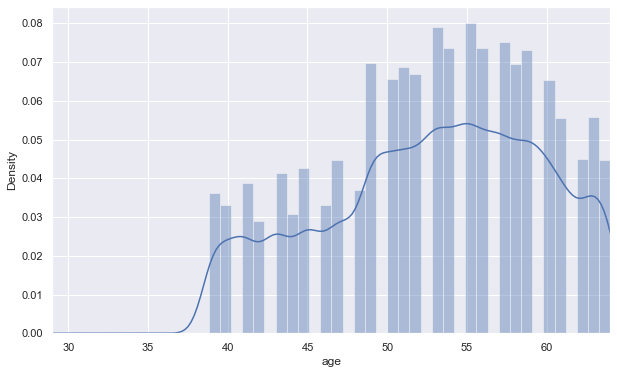

In [1062]:
# convert the values of "age" to a readable state
data.loc[:, 'age'] = data.loc[:, 'age'].apply(lambda x: int(x/365))


#turning into years
fig, ax = plt.subplots(figsize = (10, 6))

sns.distplot(data['age'])
plt.xlim(data['age'].min(),
         data['age'].max())

plt.subplots_adjust(hspace= 0.6)
plt.show()

In [1063]:
# divide the age into certain categories
data.loc[(data['age'] < 45), 'age'] = 1
data.loc[(data['age'] >= 45) & (data['age'] < 55), 'age'] = 2
data.loc[(data['age'] >= 55) & (data['age'] < 60), 'age'] = 3
data.loc[(data['age'] >= 60), 'age'] = 4

## Correlation on a dot plot

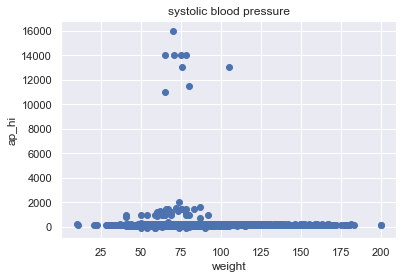

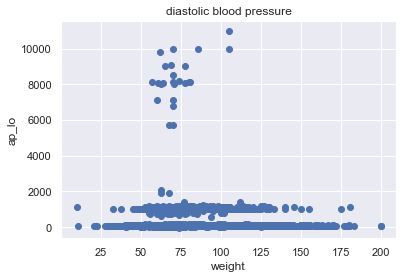

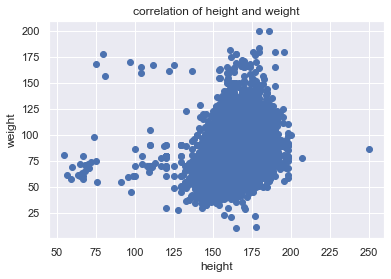

In [1066]:
# systolic blood pressure(ap_hi)
plt.scatter(data.weight, data.ap_hi)
plt.xlabel('weight')
plt.ylabel('ap_hi')
plt.title('systolic blood pressure')
plt.show()

# diastolic blood pressure
plt.scatter(data.weight, data.ap_lo)
plt.title('diastolic blood pressure')
plt.xlabel('weight')
plt.ylabel('ap_lo')
plt.show()

plt.scatter(data.height, data.weight)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('correlation of height and weight')
plt.show()



the relationship between height and weight says almost nothing, but shows interesting outliers

In [1067]:
# body mass index – BMI or the Quetelet index
# you need to divide your weight in kilograms by your height in meters squared.

def bmi(bmi):
    '''Norma – index from 19.5 to 24.9.
    Excessive thinness is below 19.5.
    Overweight: 25 to 27.9.
    Obesity 1 degree: 28-30.9.
    Obesity of 2 degrees:31-35.9.
    Obesity grade 3: 36-40.9.
    Obesity 4 degrees – the index of the more than 41.'''
    
    if 19.5 <= bmi <= 24.91:
        return 'norma'
    
    elif bmi < 19.51:
        return 'thinness'
    
    elif 24.91 <= bmi <= 27.91:
        return 'overweight'
    
    elif 27.91 <= bmi <= 30.91:
        return 'obesity 1'
    
    elif 30.91 <= bmi <= 35.91:
        return 'obesity 2'
    
    elif 35.91 <= bmi <= 40.91:
        return 'obesity 3'
    
    elif bmi > 40.9:
        return 'obesity 4'




In [1068]:
#create a column with the mass index
data['bmi'] = data_bmi.apply(lambda row: round(row.weight / (row.height / 100)**2, 1), axis=1)

# and the classification of this index
data['class_of_weight'] = data_bmi.bmi.apply(bmi)

data[data.class_of_weight.isnull() == True]


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,class_of_weight


In [1069]:
# for the Blood Pressure Category you need ap_hi / ap_lo

data['bpc'] = 0

# normal
data.loc[(data['ap_hi'] < 120) & (data['ap_lo'] < 80), 'bpc'] = 1

# elevated
data.loc[((data['ap_hi'] >= 120) & (data['ap_hi'] < 130)) &
         ((data['ap_lo'] < 80)), 'bpc'] = 2

# hypertension 1
data.loc[((data['ap_hi'] >= 130) & (data['ap_hi'] < 140)) |
         ((data['ap_lo'] >= 80) & (data['ap_lo'] < 90)), 'bpc'] = 3

# hypertension 2
data.loc[((data['ap_hi'] >= 140) & (data['ap_hi'] < 180)) |
         ((data['ap_lo'] >= 90) & (data['ap_lo'] < 120)), 'bpc'] = 4

# hypertension crisis
data.loc[(data['ap_hi'] >= 180) | (data['ap_lo'] >= 120), 'bpc'] = 5



### Analysis of two values


In [1070]:
def habitPlot(dataframe, col):
    sns.countplot(x= col,
                  hue= 'cardio',
                  data= data)
    plt.title('Comparation - {}'.format(col))
    plt.legend(['CD (─)', 'CD (+)'],
               loc= 'upper right')

In [1071]:
descriptives, results = rp.ttest(data[data['gender']==1].cardio, data[data['gender']==2].cardio)

print(descriptives.head())
print('_______________________________________________')
print(results)

# Showing descriptive statistics from researchpy.summary_cont()
rp.summary_cont(data.groupby('cardio')['gender'])

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  45530.0  0.496727  0.499995  0.002343   0.492135  0.501320
1    cardio  24470.0  0.505231  0.499983  0.003196   0.498966  0.511496
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_______________________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0085
1            Degrees of freedom =   69998.0000
2                             t =      -2.1456
3         Two side test p value =       0.0319
4        Difference < 0 p value =       0.0160
5        Difference > 0 p value =       0.9840
6                     Cohen's d =      -0.0170
7                     Hedge's g =      -0.0170
8                 Glass's delta =      -0.0170
9                             r =       0.0081




,N,Mean,SD,SE,95% Conf.,Interval
cardio,,,,,,
0,35021,1.3457,0.4756,0.0025,1.3407,1.3507
1,34979,1.3534,0.4780,0.0026,1.3484,1.3585


p_value < 0.5, it follows that the attributes are different

In [1072]:
# let's test the hypothesis that people with a cholesterol score of 2 get sick more ofte
descriptives, results = rp.ttest(data[data['cholesterol']==2].cardio, data[data['cholesterol']!=2].cardio)

print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   9549.0  0.602157  0.489478  0.005009   0.592339  0.611976
1    cardio  60451.0  0.483516  0.499732  0.002033   0.479532  0.487499
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1186
1            Degrees of freedom =   69998.0000
2                             t =      21.6191
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.2381
7                     Hedge's g =       0.2381
8                 Glass's delta =       0.2424
9                             r =       0.0814


In [1073]:
descriptives, results = rp.ttest(data[data['smoke']==1].cardio, data[data['smoke']==0].cardio)
print(descriptives)
print('_____________________________')
print(results)
stats.ttest_ind(data[data['smoke']==1].cardio, data[data['smoke']==0].cardio)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   6169.0  0.474793  0.499405  0.006358   0.462329  0.487258
1    cardio  63831.0  0.502107  0.499999  0.001979   0.498228  0.505986
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0273
1            Degrees of freedom =   69998.0000
2                             t =      -4.0976
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.0546
7                     Hedge's g =      -0.0546
8                 Glass's delta =      -0.0547
9                             r =       0.0155


Ttest_indResult(statistic=-4.097626290112295, pvalue=4.1787798766011306e-05)

Difference > 0 p value = 1.0000, so the difference in the two samples is significant. The average value for the cardio attribute in smokers is 0.47, the average value among non-smokers is 0.50, rather due to the fact that the samples have a different number of elements

   Variable         N       Mean         SD        SE  95% Conf.   Interval
0    cardio   70000.0   0.499700   0.500003  0.001890   0.495996   0.503404
1    weight   70000.0  74.205690  14.395757  0.054411  74.099045  74.312335
2  combined  140000.0  37.352695  38.234750  0.102187  37.152411  37.552979
_______________________________________________
                Independent t-test      results
0  Difference (cardio - weight) =      -73.7060
1            Degrees of freedom =   139998.0000
2                             t =    -1353.8031
3         Two side test p value =        0.0000
4        Difference < 0 p value =        0.0000
5        Difference > 0 p value =        1.0000
6                     Cohen's d =       -7.2364
7                     Hedge's g =       -7.2363
8                 Glass's delta =     -147.4110
9                             r =        0.9639


Ttest_indResult(statistic=1315.206493021443, pvalue=0.0)

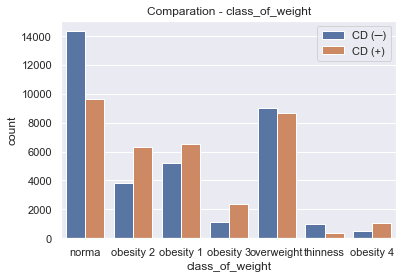

In [1074]:
descriptives, results = rp.ttest(data.cardio, data.weight)

print(descriptives.head())
print('_______________________________________________')
print(results)
habitPlot(data, 'class_of_weight')

# using t-test statistics, we will check the relationships between several variables
stats.ttest_ind(data.weight, data.age)

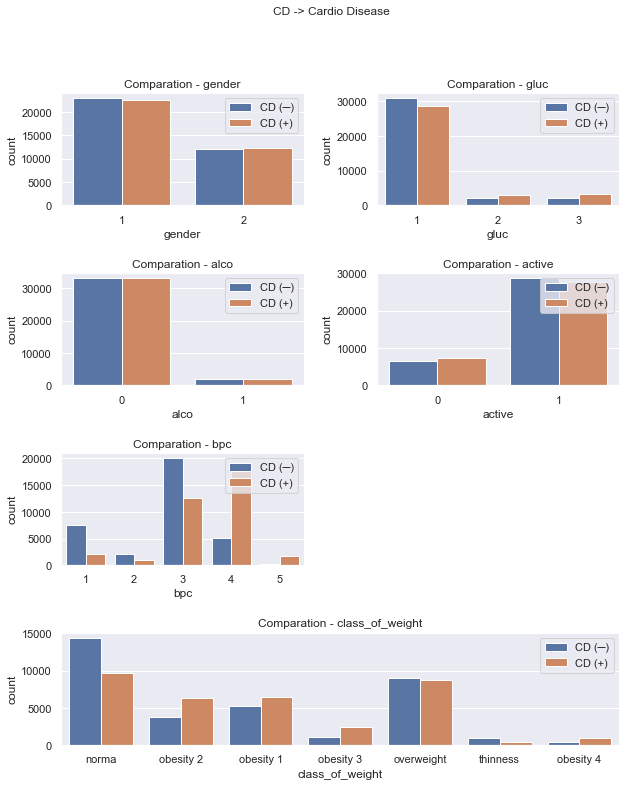

In [1075]:
fig, ax = plt.subplots(figsize = (10, 12))
fig.suptitle('CD -> Cardio Disease')

plt.subplot(4,2,1)
habitPlot(data, 'gender')

plt.subplot(4,2,2)
habitPlot(data, 'gluc')


plt.subplot(4,2,3)
habitPlot(data, 'alco')

plt.subplot(4,2,4)
habitPlot(data, 'active')

plt.subplot(4,2,5)
habitPlot(data, 'bpc')

plt.subplot(4,1,4)
habitPlot(data, 'class_of_weight')

plt.subplots_adjust(hspace= 0.6, wspace= 0.3)
plt.show()

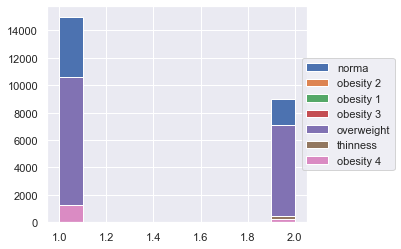

In [1077]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

for _class in data.class_of_weight.unique():
    ax.hist(data[data.class_of_weight == _class].gender)
    ax.legend(data.class_of_weight.unique(),loc = 'right', borderaxespad=-8)
plt.show()

since the number of males and females is different, it can be seen that the bmi classification is proportional to the adjacent column, so trends and differences in mass correlate with gender

In [1078]:

data.loc[(data['bmi'] < 19.5), 'bmi'] = 1
data.loc[(data['bmi'] >= 19.5) & (data['bmi'] < 24.9), 'bmi'] = 2
data.loc[(data['bmi'] >= 24.9) & (data['bmi'] < 30.9), 'bmi'] = 3
data.loc[(data['bmi'] >= 27.9) & (data['bmi'] < 35.9), 'bmi'] = 4
data.loc[(data['bmi'] >= 30.9) & (data['bmi'] < 40.9), 'bmi'] = 5
data.loc[(data['bmi'] >= 40.9), 'bmi'] = 6


In [1079]:
data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,class_of_weight,bpc
0,2,2,168,62.0,110,80,1,1,0,0,1,0,2.0,norma,3
1,3,1,156,85.0,140,90,3,1,0,0,1,1,4.0,obesity 2,4
2,2,1,165,64.0,130,70,3,1,0,0,0,1,2.0,norma,3
3,2,2,169,82.0,150,100,1,1,0,0,1,1,3.0,obesity 1,4
4,2,1,156,56.0,100,60,1,1,0,0,0,0,2.0,norma,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2,2,168,76.0,120,80,1,1,1,0,1,0,3.0,overweight,3
69996,4,1,158,126.0,140,90,2,2,0,0,1,1,6.0,obesity 4,4
69997,2,2,183,105.0,180,90,3,1,0,1,0,1,4.0,obesity 2,5
69998,4,1,163,72.0,135,80,1,2,0,0,0,1,3.0,overweight,3


since we have the necessary indexes, you can remove the extra columns so that they do not interfere with the calculations

In [1080]:
unnecessary_columns = ['height','weight','ap_hi','ap_lo','class_of_weight']
data.drop(unnecessary_columns, inplace=True, axis=1)

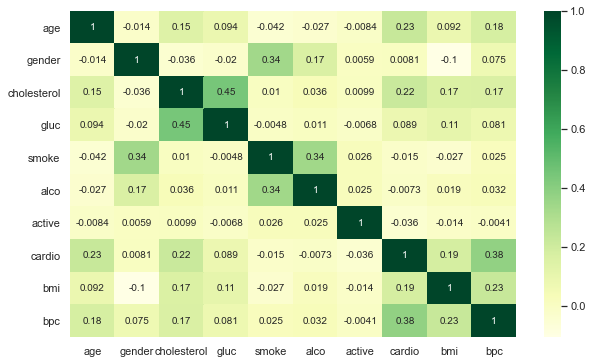

In [1081]:
# the correlation matrix
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(data.corr(), annot= True,
            cmap= 'YlGn')
plt.show()

In [1083]:
# make sure that the dataset data is suitable for the model
data

,age,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,bpc
0,2,2,1,1,0,0,1,0,2.0,3
1,3,1,3,1,0,0,1,1,4.0,4
2,2,1,3,1,0,0,0,1,2.0,3
3,2,2,1,1,0,0,1,1,3.0,4
4,2,1,1,1,0,0,0,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...
69995,2,2,1,1,1,0,1,0,3.0,3
69996,4,1,2,2,0,0,1,1,6.0,4
69997,2,2,3,1,0,1,0,1,4.0,5
69998,4,1,1,2,0,0,0,1,3.0,3


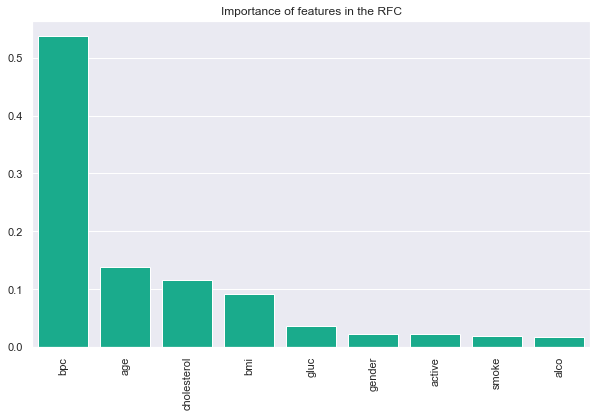

In [1084]:
# Applying a base model to verify the importance of it
rfc = RandomForestClassifier()
rfc.fit(data.drop(['cardio'], axis= 1), data['cardio'])

# Discovering the importance of features in the model
tmp = pd.DataFrame({'Columns': data.drop(['cardio'], axis= 1).columns,
                    'Importance': rfc.feature_importances_})
tmp = tmp.sort_values(by = 'Importance', ascending = False)

# Plotting a graph about it
fig, ax = plt.subplots(figsize = (10, 6))

sns.barplot(data = tmp,
             x = 'Columns',
             y = 'Importance',
           color = '#02c39a')
plt.title('Importance of features in the RFC')
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('')

plt.show()

### receiver operating characteristic

In [1085]:
# restore this dataset for other operations
data = pd.read_csv(url,sep=";")
x, y = data.drop(['id', 'cardio'], axis=1), data.cardio
data.drop_duplicates(inplace= True)

In [1086]:
# normalizing the data
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0


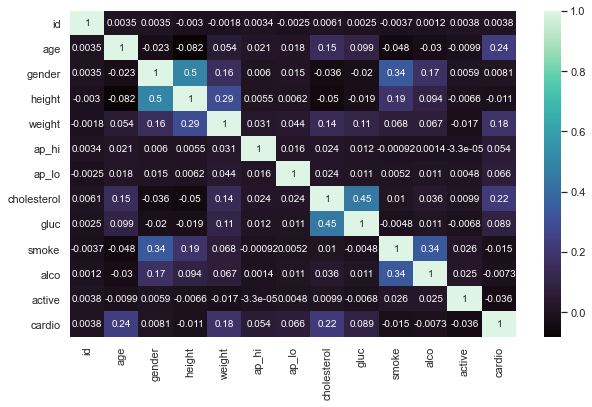

In [1090]:
# correlation matrix for all features
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(data.corr(), annot= True,
            cmap= 'mako')
plt.show()

If you trust this data, you can see that the value of growth depends on gender. Smoking and alcoholism are also positively correlated with gender

In [1091]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_norm,y, test_size = 0.2, random_state = 42)

In [1092]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
print("the accuracy of our model: {}".format(nb.score(x_test,y_test)))

the accuracy of our model: 0.5932857142857143


In [1093]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68      6988
           1       0.71      0.32      0.44      7012

    accuracy                           0.59     14000
   macro avg       0.64      0.59      0.56     14000
weighted avg       0.64      0.59      0.56     14000



In [1094]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)
lr.fit(x_train,y_train)
print("our accuracy is: {}".format(lr.score(x_test,y_test)))

our accuracy is: 0.6545714285714286


In [1095]:
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      6988
           1       0.66      0.63      0.65      7012

    accuracy                           0.65     14000
   macro avg       0.66      0.65      0.65     14000
weighted avg       0.66      0.65      0.65     14000



Very low recall - this may be due to unbalanced classes. Let's compare the Naive Bayes model with the Random Forest model:

In [1096]:
from sklearn.ensemble import RandomForestClassifier

# creating the decision trees model
# select 100 trees as a parameter
model=RandomForestClassifier(n_estimators=100)

# training the model
model.fit(x_train,y_train)

RandomForestClassifier()

In [1097]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))


              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6988
           1       0.72      0.70      0.71      7012

    accuracy                           0.71     14000
   macro avg       0.72      0.72      0.71     14000
weighted avg       0.72      0.71      0.71     14000



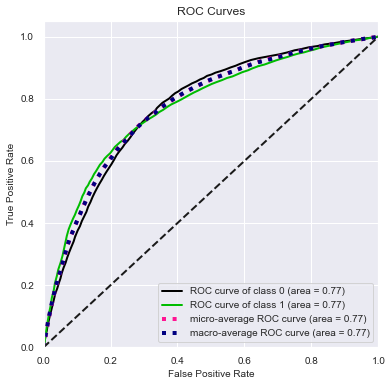

In [1098]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test

y_probas = model.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas, figsize=(6, 6))
plt.show()

##### true-positive result (true positive, TP) — a sick patient, the diagnosis is positive; false positive (false positive, FP) — the patient is healthy, a positive diagnosis; true negative (true negative, TN) — the patient is healthy, the diagnosis is negative; false negative result (false negative, FN) — sick patient, the diagnosis is negative.

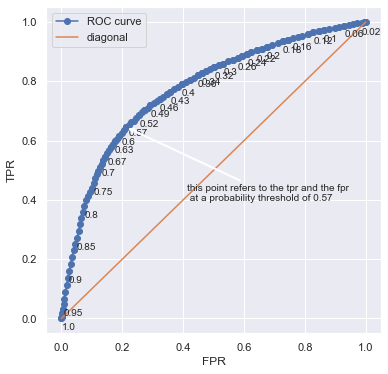

In [1099]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas[:, 1])

# %%
plt.subplots(figsize=(6, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[1::5], tpr[1::5], thresholds[1::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 1 * len(tpr)//3
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()